<a href="https://colab.research.google.com/github/mtcarilli/bursty-deg-cme/blob/main/gammaDegradation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import scipy

import matplotlib.pyplot as plt

In [2]:
updateRules = np.array([1,     #  N --> N+1
                        -1],    #  N --> N-1
                      )


def getPropensities(X,args):
  '''Returns state switching propensities given current state X and args, a dictionary of rates.
  '''

  P1 = args['k']
  lam = args['lambda']
  P2 = lam*X

  return np.array([P1,P2])

def updateState(X,propensities,updateRules):
  '''Samples a reaction given propensities and updates the state vector X accordingly.
  '''
  propensities = propensities/propensities.sum()
  j = np.random.choice(np.arange(len(propensities)),p=propensities)

  X = X + updateRules[j]
  return X

def sampleTau(propensities):
  '''Samples a time step given propensities.
  '''
  tau = np.random.exponential(1. / propensities.sum())
  # r1 = np.random.rand()
  # tau = (1/propensities.sum())*np.log(1/r1)
  return tau

def runRxn(initcond,T,args,updateRules):
  '''Given system initial condition (prob of being in State 1 and State 2) and args, simulate one statistically valid trajectory up to time T.
  '''
  t = 0
  X = initcond
  while t<T:
    propensities = getPropensities(X,args)
    tau = sampleTau(propensities)
    X = updateState(X,propensities,updateRules)
    t = t + tau

  return(X)


def runRxns(initcond,T,args,updateRules,N):
  '''Simulate N trajectories up to time T.
  '''
  rxns = np.zeros((N,1))
  for n in range(N):
    lam = np.random.gamma(args['alpha'])  # sample from gamma distribution with shape alpha
    args_ = {'k' : args['k'], 'lambda' : lam}
    X = runRxn(initcond,T,args_,updateRules)
    rxns[n,:] = X

  return rxns


# analytical solution

def analyticalSolutionPSS(n,args):
  '''Possible analytical solution to gamma distributed degradation rate.'''
  alpha = args['alpha']
  k = args['k']

  prefactor_num = 2 * k**((alpha-n)/2 + n)
  prefactor_denom = scipy.special.factorial(n)*scipy.special.gamma(alpha)
  prefactor = prefactor_num/prefactor_denom

  bessel =  scipy.special.kv(alpha-n,2*np.sqrt(k))  # Modified Bessel function of the second kind of real order v
  PSS = prefactor*bessel
  return PSS

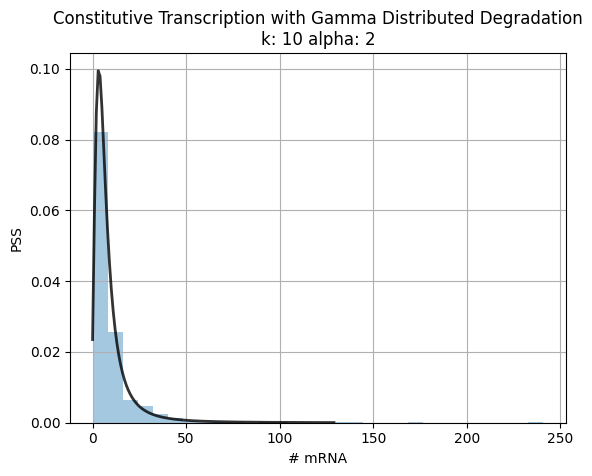

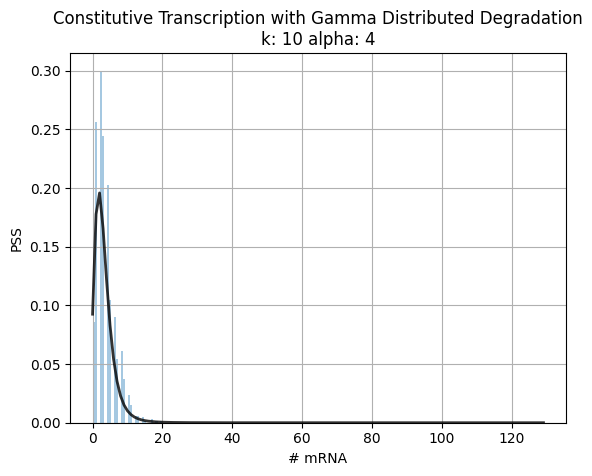

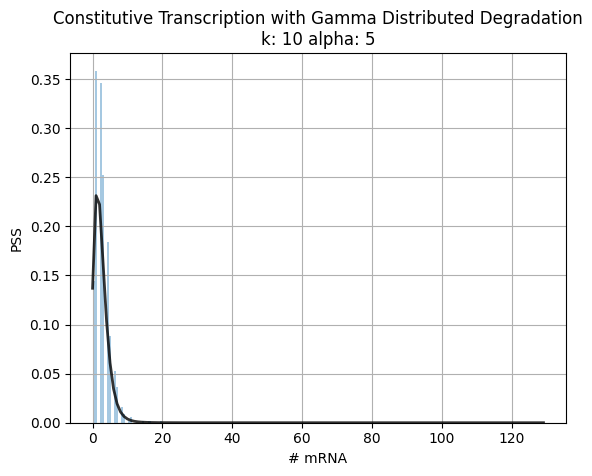

In [7]:
T = 100
k = 10
for alpha in [2,4,5,]:
  args_ = {'k' : k, 'alpha' : alpha}
  rxns = runRxns(0,T,args_,updateRules,1000)
  PSS = analyticalSolutionPSS(np.arange(0,130),args_)

  plt.plot(PSS,color='black',linewidth=2,alpha=0.8)

  plt.hist(rxns,density=True,alpha=0.4,bins=30)
  plt.xlabel('# mRNA')
  plt.ylabel('PSS')
  plt.title(f'Constitutive Transcription with Gamma Distributed Degradation\nk: {k} alpha: {alpha}')
  plt.grid()
  plt.show()
